## What's new in this implementation
<font color="red">
   In previous DNN implementation I had forgotten  to include the dropout effect in the backpropagation. (Noticed while going through the Coursera lab!)<br/>
    Here I correct it.
</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import HTML,Latex
import os 
from joblib import Parallel,delayed
import json
import cv2 as cv
import pprint

In [2]:
PARAM_FOLDER_NAME = 'parameters_as_json/'
class DNN:
    def __init__(self,layers):
        # layers :  list of dicts containing later information.
        assert type(layers) in  (list,tuple)
        assert len(layers) >= 2, "At least an input and an output layer should be there"
        
        # validate each layer
        for i,layer in enumerate(layers):
            if i==0:
                assert layer["type"] == "input", "first layer should be input"
            elif i==len(layers)-1:
                assert layer["type"] == "output", "last layer should be output"
            else:
                assert layer["type"] == "hidden", "middle layers should be hidden"
                assert layer["activation_function"] in ACTIVATION_FUNC
                
            assert type(layer["units"]) == int
            
            #if the reqularization term is not mentioned --> assign 0.0
            if 'regularization_strength' not in layer:
                layer['regularization_strength'] = 0.0
            # if the keep prob is not mentioned --> assign 1.0
            if 'dropout_keep_prob' not in layer:
                layer['dropout_keep_prob'] = 1.0
            
            #validate the regularization and keep prob values
            assert type(layer['regularization_strength']) == type(layer['dropout_keep_prob']) == float,\
                    "regularization_strength and dropout_keep_prob should be float"
                
        #done: validation
        
        #save these info
        self.layers = layers
        
        #keep state variables
        self.ever_trained = 0
        self.total_iterations = 0;
        self.parameters_as_json_files = []
        
        #costs need to be saved separately per each training
        self.cost_history = []
        
    def absorb_parameters(self,W,B):
        self.W=W
        self.B=B
        
    def load_history_state(self,history_state):
        history_state = str(history_state)
        # only need the random float --> format if underscore and some other things in the given name
        if '_' in history_state:
            history_state = history_state.split('_')[0]
        if not history_state.startswith('0.'):
            history_state = '0.' + history_state
        #open the jason file and load the parameters
        with open(PARAM_FOLDER_NAME + history_state + '_params.json','r') as file:
            all_params =  json.load(file)
            all_params['W'] = [np.array(w) if w is not None else None for w in all_params['W']]
            all_params['B'] = [np.array(b) if b is not None else None for b in all_params['B']]
            self.absorb_parameters(all_params['W'],all_params['B'])
            print('\033[31m Reset the parameters according to history state : ' + history_state,'\033[30m')
            self.parameters_as_json_files.append(history_state + '_params.json')
        
        
    def build(self,show=0,weight_init_noise_amplitude=0.01):
        # the parameters will be initialized with required dimentions
        
        self.W = [None] # this array will keep weight matrix  per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        self.B = [None] # this array will keep bias vector  per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        self.activation_def = [None] # the pointer to respecting activation function's definition per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        self.activation_derivative_def = [None] # the pointer to respecting activation function's derivative's  
                                                                #definition per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        
        self.A = [] # keep all intermidiate activation matrix per each layer (l=1,2,..,L)
        self.Z = [] # keep all intermidiate pre-activation matrix per each layer (l=1,2,..,L)
        
        #initializing
        for i in range(len(self.layers)):
            
            # anything for l=0,1,2,..,L ? 
            # NO
             
            
            if i: #only start from layer 1,2,..,L
                weight_matrix = np.float32(np.random.randn(self.layers[i]["units"],self.layers[i-1]["units"]) * weight_init_noise_amplitude)
                bias_vector = np.zeros((self.layers[i]["units"],1),dtype=np.float32)
                self.W.append(weight_matrix)
                self.B.append(bias_vector)
                   
               
                self.activation_def.append(ACTIVATION_FUNC[self.layers[i]["activation_function"]])
                self.activation_derivative_def.append(ACTIVATION_FUNC_DERI[self.layers[i]["activation_function"]])
           
            
        if show: 
            print(self.W) 
            print(self.B)
            
            
    def show_cost_history(self,log=0):
        PLOT_COLORS = ['blue','red','green','orange']
        fig,ax = plt.subplots(1)
        pointer = 0
        for i in range(len(self.cost_history)):
            if not log:
                ax.plot(list(range(pointer,pointer:=pointer + len(self.cost_history[i]))),
                    self.cost_history[i],
                    color = PLOT_COLORS[i%len(PLOT_COLORS)])
            else: # need to plot the log of costs
                ax.plot(list(range(pointer,pointer:=pointer + len(self.cost_history[i]))),
                    np.log(self.cost_history[i]),
                    color = PLOT_COLORS[i%len(PLOT_COLORS)])
                
        #generate a title for the plot
        plot_title = f'Cost vs. iterration '
        if log:
            plot_title += ':: LOG'
        ax.set_title(plot_title)
        plt.show()
        
        
    def predict(self,X):
        X = np.array(X,dtype=np.float32)
        
        
        # these are some place holders to keep the arrays in required size
        self.A = [None for i in range(len(self.layers))]
        self.Z = [None for i in range(len(self.layers))]
        self.A[0] = X # the input matrix
        
       
        for i in range(1,len(self.layers)):
                    self.Z[i] = self.W[i]@self.A[i-1]+self.B[i]
                    self.A[i] = self.activation_def[i](self.Z[i])
        # now all the activations in the NN are calculated and stored
        
        return self.A[len(self.layers) - 1]
        
        
       
        
    
        
        
    def batch_fit(self,X,Y,cost_function='least_square',
                  n_iters=1_000,learning_rate=1e-3,
                  ADAM=True,beta_1=0.9,beta_2=0.99,adam_epsilon=1e-2):
        
        assert cost_function in ('least_square','binary_cross_entropy')
        Y = np.float32(Y)
        X = np.float32(X)
      
        
        if not self.ever_trained:
            # these are some place holders to keep the arrays in required size
            self.A = [None for i in range(len(self.layers))]
            self.Z = [None for i in range(len(self.layers))]

            self.dZ = [None for i in range(len(self.layers))]
            self.dA = [None for i in range(len(self.layers))]
            self.dW = [None for i in range(len(self.layers))]
            self.dB = [None for i in range(len(self.layers))]
            
            #placeholders for dropout vectors per each layer
            self.dropout_vectors = [None] * (len(self.layers)-1) #for the output layer no need of dropout vector
            
             # For ADAM, initialize the following
            if ADAM:
                self.__initialize_RMSprop_with_zeros()
                self.__initialize_momentum_with_zeros()
            
            
        else:
            print("Training again..fine tuning of parameters continued from where left at last time...")

        #update the state variable
        self.ever_trained += 1
            
        self.A[0] = X # set the input matrix 
        
        
       
        
        start_time = time.time()
        self.cost_history.append([])
        for iteration in range(n_iters): 
            
                # progress message : every 100 iteration except for the first one
                if iteration and not iteration%10:
                        time_now = time.time()
                        time_remaining = get_nice_time_dura_str ((n_iters - iteration) * (time_now - start_time) / iteration)
                        print(f"iteration : {iteration} ---> ETA : {time_remaining} ",end="\r")
                # end : progress message
            
            
            
                ##### FWD PASS #####
                #  r3ki3g : assumes the X in pre-scaled / normalized
                
                # apply droput settings for the input layer only
                should_not_drop = np.random.rand(*self.A[0].shape) < self.layers[0]["dropout_keep_prob"]
                self.dropout_vectors[0] = should_not_drop
                self.A[0] *= should_not_drop /  self.layers[0]["dropout_keep_prob"]

                # loop though each layer and calculate the pre-activations(Z) and activations(A)
                cost_reg_term = 0
                for i in range(1,len(self.layers)):
                    self.Z[i] = self.W[i]@self.A[i-1]+self.B[i]
                    self.A[i] = self.activation_def[i](self.Z[i])
                    
                    # consider the drop-out settings (except in ouput layer)
                    if i != len(self.layers)-1:
                        should_not_drop = np.random.rand(*self.A[i].shape) <= self.layers[i]["dropout_keep_prob"]
                        self.dropout_vectors[i] = should_not_drop
                        self.A[i] *= should_not_drop /  self.layers[i]["dropout_keep_prob"]
                    
                    #iclude the regularization term in cost function (temp:cost_reg_term )
                    cost_reg_term += np.sum(self.W[i]**2) * self.layers[i]["regularization_strength"] / X.shape[1]
                    
                # now all the activations in the NN are calculated and stored
                
                
                # now calculate the cost at this iteration
                if cost_function == 'binary_cross_entropy':
                    # 1e-8 added inside log functions to avoid occuring log(0)
                    cost = - np.sum((Y * np.log(1e-8 + self.A[len(self.layers) - 1]) + (1.-Y) * np.log(1e-8 + 1. - self.A[len(self.layers) - 1]))) /  X.shape[1] 
                elif cost_function == 'least_square':
                     cost = np.sum((self.A[len(self.layers) - 1] - Y)**2) / X.shape[1]
                else:
                    raise Exception("not implemented yet")
                
                #inlcude the regularization term in cost function
                cost += cost_reg_term
                self.cost_history[-1].append(cost)
                # done : cost calc and stroing

               

                ##### BACK PROP #####
                # The order l = L,L-1,L-2,...,3,2,1 (and no 0)
                for i in range(len(self.layers) -1 , 0 , -1): # i=0 is excluded  # note :- L is at  len(self.layers) -1 index

                    # the output layer pre-activation AKA dZ[L] depends on the choice of cost function
                    if i == len(self.layers) -1:
                                if cost_function == 'binary_cross_entropy':
                                    dL_dA = -(Y/self.A[i]) +((1-Y)/(1-self.A[i]))   
                                        
#                                        
                                elif cost_function == 'least_square':
                                    dL_dA = 2 * (self.A[i] - Y)
                                    
                                   
                                    
                                # finally we need the dZ (independent from cost function)
                                self.dZ[i] = dL_dA * self.activation_derivative_def[i](self.Z[i])



                    else: # not the last layer
                        self.dZ[i] =  (self.W[i+1].T @ self.dZ[i+1]) * self.activation_derivative_def[i](self.Z[i])
                        # dropout affects backpropagation as well
                        self.dZ[i] *= self.dropout_vectors[i] / self.layers[i]["dropout_keep_prob"]
                    
                    
                    # calculate gradients
                    m = X.shape[1]
                    self.dW[i] = self.dZ[i]@self.A[i-1].T / m
                    self.dB[i] = np.sum(self.dZ[i],axis=1,keepdims=1) / m

                    # gradient decent
                    # ADAM optimization has to be considered 
                    
                    if 'keep a record of the previous state':
                        vdWh = self.vdW[i]
                        vdBh = self.vdB[i]
                        sdWh = self.sdW[i]
                        sdBh = self.sdB[i]
                    
                    
                    self.vdW[i] = beta_1 * self.vdW[i]  + (1. - beta_1) * self.dW[i]
                    self.vdB[i] = beta_1 * self.vdB[i]  + (1. - beta_1) * self.dB[i]
                    self.sdW[i] = beta_2 * self.sdW[i]  + (1. - beta_2) * self.dW[i]**2
                    self.sdB[i] = beta_2 * self.sdB[i]  + (1. - beta_2) * self.dB[i]**2
                  

                    vdW = self.vdW[i] / (1. - beta_1**(iteration+1))
                    vdB = self.vdB[i] / (1. - beta_1**(iteration+1))
                    sdW = self.sdW[i] / (1. - beta_2**(iteration+1))
                    sdB = self.sdB[i] / (1. - beta_2**(iteration+1))
                    
                    
                    if not 'print the error caused states':
                        
                        if (np.any(np.isnan(vdW))):
                            print("nan detedted",iteration)
                            print("vdWh",vdWh)
                            print("end")
                        if (np.any(np.isnan(vdB))):
                            print("nan detedted",iteration)
                            print("vdBh",vdBh)
                            print("end")
                        if (np.any(np.isnan(sdW))):
                            print("nan detedted",iteration)
                            print("sdWh",sdWh)
                            print("end")
                        if (np.any(np.isnan(sdB))):
                            print("nan detedted",iteration)
                            print("sdBh",sdBh)
                            print("end")


    #                     if iteration<4 or iteration>n_iters-2:
    #                         print("vdW",vdW)

    #                         print("vdB",vdB)

    #                         print("sdW",sdW)
    #                         print("sdB",sdB)

                    
                  
                    # the regularization has to be included here
                    reg_lambda =  self.layers[i]['regularization_strength']
                    
#                     self.W[i] = (1 - reg_lambda*learning_rate/m) * self.W[i] \
#                                 - (learning_rate / ( np.sqrt(np.abs(self.sdW[i])) + adam_epsilon) ) * self.vdW[i]
#                     self.B[i] = self.B[i] \
#                                 - (learning_rate / (np.sqrt(np.abs(self.sdB[i])) + adam_epsilon) ) * self.vdB[i]
                    
    
                    self.W[i] = (1 - reg_lambda*learning_rate/m) * self.W[i] \
                                - (learning_rate / ( np.sqrt(sdW + 1e-8) + adam_epsilon) ) * vdW
                    self.B[i] = self.B[i] \
                                - (learning_rate / ( np.sqrt(sdB + 1e-8) + adam_epsilon) ) * vdB

        #update the state variables
        self.total_iterations += n_iters
        
        time_now = time.time()
        total_time = get_nice_time_dura_str(time_now - start_time)
        print(f"Training ({self.ever_trained}) ended  : n_iters: {n_iters} with learning_rate : {learning_rate}. Time taken : {total_time}")
        print(f'Total summary :: iterrations : {self.total_iterations}')
        
        #saving the weights in to a file
        self.__save_current_learnt_params()
        
    def history(self):
        print('Follwoing history sates are available:')
        print(self.parameters_as_json_files)
        print("Use DNN.load_history_state(history_state) to reset parameters to any state.")
        print("Use DNN.back() to ignore last training and return to the previous state.")
        
    def back(self):
        undo_last__filename = self.parameters_as_json_files[-2]
        self.load_history_state(undo_last__filename)
        self.parameters_as_json_files.append(undo_last__filename)
        print("Last training was ignored and returned to the previous state: " + undo_last__filename)
    
    def layer(self,name):
        selected_layer = None
        for layer in self.layers:
            if 'name' in layer and layer['name'] == name:
                if selected_layer == None:
                    selected_layer = layer
                else:
                    raise Exception("Found multiple layers with name : " +  name)
        if selected_layer == None:        
            raise Exception("No layer with the name : " + name)
        return selected_layer
        
                
            
    def __initialize_momentum_with_zeros(self):
        self.vdW = [np.zeros(layer_w.shape,dtype=np.float32) if layer_w is not None else None for layer_w in self.W]
        self.vdB = [np.zeros(layer_b.shape,dtype=np.float32) if layer_b is not None else None for layer_b in self.B]
    def __initialize_RMSprop_with_zeros(self):
        self.sdW = [np.zeros(layer_w.shape,dtype=np.float32) if layer_w is not None else None for layer_w in self.W]
        self.sdB = [np.zeros(layer_b.shape,dtype=np.float32) if layer_b is not None else None for layer_b in self.B]

    def __save_current_learnt_params(self):
        #generate a random name for the training-history-point
        this_status_name = str(np.random.rand()) + '_params.json'
        #make a 'parameters as json' folder if it does not exist already
        
        if not os.path.isdir(PARAM_FOLDER_NAME):os.mkdir(PARAM_FOLDER_NAME)
        with open(PARAM_FOLDER_NAME + this_status_name,'w') as file:
            weights = [w.tolist() if not w is None else None for w in self.W]
            biases = [b.tolist() if not b is None else None for b in self.B]
            all_params = {"W":weights,"B":biases}
            json.dump(all_params,file)
            
        self.parameters_as_json_files.append(this_status_name)
        print("saved params to: " + this_status_name)
        
                      

    
    
###### HELPER FUNCTIONS FOR DNN CLASS ###########    
    
# define activation functions globally
def sigmoid(t):
        return 1/ ( 1 + np.exp(-t) )
      
def relu(t): # from chat gpt : this is safe for any dimension array t
    return np.maximum(0,t)

def relu_deri(t):
    return np.where(t>=0,1.,0.)

def sigmoid_deri(t):
    return (1-sigmoid(t)) * sigmoid(t)

def linear(t):
    return t

def linear_deri(t):
    return 1

def tanh(Z):
    return np.tanh(Z)

def tanh_deri(Z):
    return 1 - np.tanh(Z)**2
                
ACTIVATION_FUNC = {"relu":relu,"sigmoid":sigmoid,"linear":linear,"tanh":tanh}
ACTIVATION_FUNC_DERI = {"relu":relu_deri,"sigmoid":sigmoid_deri,"linear":linear_deri,"tanh":tanh_deri}




# helper function for displaying ETA in a nice manner
def get_nice_time_dura_str(time_in_secs):
    time_in_secs = round(time_in_secs,2)
    if time_in_secs >= 60:
        n_mins = int(time_in_secs//60)
        n_secs = round(time_in_secs%60,2)
        return f"{n_mins} min {n_secs} secs"
    return f"{time_in_secs} secs"



In [3]:
# data set processing
basedir = '''D:/ENTC/PROJECTS/digit-recognition-with-convolution-from-scratch/MNIST Dataset JPG format/MNIST Dataset JPG format/'''
train_basedir = basedir + '''training/'''

N_EXAMPLES_PER_CLASS = 4000


all_training_example = []
for i in range(10):
    # integer = i
    this_file_path = train_basedir  +  str(i) + '/'
    files = os.listdir(this_file_path)
    assert len(files)>=N_EXAMPLES_PER_CLASS
    files = files[:N_EXAMPLES_PER_CLASS]
    
    all_images_for_class_i  = np.zeros((28*28,N_EXAMPLES_PER_CLASS))
    for j,filepath in enumerate(files):
        img = cv.imread(this_file_path + filepath,0) #gray scale:: each image ==> (2d array)
        assert img is not None
        img = cv.GaussianBlur(img,(11,11),4)
        img_flattened = img.reshape(-1)
        all_images_for_class_i[:,j] = img_flattened
    all_training_example.append(all_images_for_class_i)





In [4]:
all_training_example[0].shape


(784, 4000)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


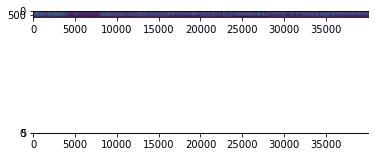

In [5]:
# making entire training set
X_train = np.concatenate((all_training_example[0],
                         all_training_example[1],
                         all_training_example[2],
                         all_training_example[3],
                         all_training_example[4],
                         all_training_example[5],
                         all_training_example[6],
                         all_training_example[7],
                         all_training_example[8],
                         all_training_example[9]),axis=1)

X_train /= 255 # to normalize


def onehot(index,size):
    vector = np.zeros((size,1))
    vector[index,0] = 1
    return vector

all_training_onehot_y = []
for i in range(10):
    this_onehot_vector = onehot(i,10)
    all_training_onehot_y.append(np.tile(this_onehot_vector,(1,N_EXAMPLES_PER_CLASS)))

#print a test
print(all_training_onehot_y[7][:,1])

Y_train = np.concatenate((all_training_onehot_y[0],
                         all_training_onehot_y[1],
                         all_training_onehot_y[2],
                         all_training_onehot_y[3],
                         all_training_onehot_y[4],
                         all_training_onehot_y[5],
                         all_training_onehot_y[6],
                         all_training_onehot_y[7],
                         all_training_onehot_y[8],
                         all_training_onehot_y[9]),axis=1)

fig,ax = plt.subplots(2)
ax[0].imshow(X_train)
ax[1].imshow(Y_train)

In [ ]:
n_input = 784     # =  28 * 28
n_output = 10
int_recog_NN = DNN(layers=[

    {
        "type":"input",
        "units":n_input
    },

   
    {
        "type":"hidden",
        "units":100,
        "activation_function":"tanh",
        "regularization_strength":1e2,
        "dropout_keep_prob":1.0,
        "name":"fhl"
    },
    
    {
        "type":"hidden",
        "units":20,
        "activation_function":"tanh",
        "regularization_strength":1e2,
        "dropout_keep_prob":1.0,
        "name":"shl"
    },
    
#     {
#         "type":"hidden",
#         "units":n_input//8,
#         "activation_function":"relu",
#         "regularization_strength":0.0,
#         "dropout_keep_prob":1.0,
#         "name":"thl"
#     },
  
    
    {
        "type":"output",
        "units":n_output,
        "activation_function":"sigmoid",
        "regularization_strength":0.0,
        "dropout_keep_prob":1.0
    }

])

int_recog_NN.build(weight_init_noise_amplitude=0.01)

int_recog_NN.batch_fit(X_train,
                       Y_train,
                       cost_function=('least_square','binary_cross_entropy')[0],
                       n_iters=1_0,
                       learning_rate=1e-4,beta_1=0.9,beta_2=0.99)

%matplotlib inline
int_recog_NN.show_cost_history(log=1)

display(HTML(f' <font size="5" color="red"> Final cost: {int_recog_NN.cost_history[-1][-1]}</font>'))




In [ ]:
int_recog_NN.history()
# int_recog_NN.back()
int_recog_NN.layer('fhl')['regularization_strength']=1e1
int_recog_NN.layer('shl')['regularization_strength']=1e1

In [ ]:
int_recog_NN.batch_fit(X_train,
                       Y_train,
                       cost_function=('least_square','binary_cross_entropy')[0],
                       n_iters=1_00,
                       learning_rate=5e-2)

%matplotlib inline
int_recog_NN.show_cost_history(log=1)

display(HTML(f'<font size="5" color="red"> Final cost : {int_recog_NN.cost_history[-1][-1]}</font>'))
int_recog_NN.history()

In [ ]:
int_recog_NN.history()
int_recog_NN.back()

In [ ]:

# cross validation

# data set processing
basedir = '''D:/ENTC/PROJECTS/digit-recognition-with-convolution-from-scratch/MNIST Dataset JPG format/MNIST Dataset JPG format/'''
dev_basedir = basedir + '''testing/'''

N_EXAMPLES_PER_CLASS = 100


all_dev_example = []
for i in range(10):
    # integer = i
    this_file_path = dev_basedir + str(i) + '/'
    files = os.listdir(this_file_path)
    assert len(files) >= N_EXAMPLES_PER_CLASS
    files = files[:N_EXAMPLES_PER_CLASS]

    all_images_for_class_i = np.zeros((28*28, N_EXAMPLES_PER_CLASS))
    for j, filepath in enumerate(files):
        # gray scale:: each image ==> (2d array)
        img = cv.imread(this_file_path + filepath, 0)
        assert img is not None
        img = cv.GaussianBlur(img,(11,11),4)
        img_flattened = img.reshape(-1)
        all_images_for_class_i[:, j] = img_flattened
    all_dev_example.append(all_images_for_class_i)


# making entire training set
X_dev = np.concatenate((all_dev_example[0],
                        all_dev_example[1],
                        all_dev_example[2],
                        all_dev_example[3],
                        all_dev_example[4],
                        all_dev_example[5],
                        all_dev_example[6],
                        all_dev_example[7],
                        all_dev_example[8],
                        all_dev_example[9]), axis=1)

X_dev /= 255 # normalize

all_training_onehot_y = []
for i in range(10):
    this_onehot_vector = onehot(i, 10)
    all_training_onehot_y.append(
        np.tile(this_onehot_vector, (1, N_EXAMPLES_PER_CLASS)))

# print a test
print(all_training_onehot_y[7][:, 1])

Y_dev = np.concatenate((all_training_onehot_y[0],
                        all_training_onehot_y[1],
                        all_training_onehot_y[2],
                        all_training_onehot_y[3],
                        all_training_onehot_y[4],
                        all_training_onehot_y[5],
                        all_training_onehot_y[6],
                        all_training_onehot_y[7],
                        all_training_onehot_y[8],
                        all_training_onehot_y[9]), axis=1)

fig, ax = plt.subplots(2)
ax[0].imshow(X_dev)
ax[1].imshow(Y_dev)

pred_dev = int_recog_NN.predict(X_dev)


dev_cost = np.sum((pred_dev - Y_dev)**2) / X_dev.shape[1]
display(
    HTML(f'<font color="red" size="5">Cross validation cost: {dev_cost}</font>'))


### See the wrongly predicted from testings

In [ ]:
testing_path = 'D:/ENTC/PROJECTS/digit-recognition-with-convolution-from-scratch/MNIST Dataset JPG format/MNIST Dataset JPG format/testing/9/'

allimg = []

allfiles = os.listdir(testing_path)
for filepath in allfiles:
    
    img = cv.imread(testing_path +filepath ,0)
    assert img is not None
    img = cv.GaussianBlur(img,(11,11),4)

    imgf = img.reshape(-1,1)
  
    allimg.append(imgf)


allimg = np.array(allimg).T.reshape(784,-1)


preds = int_recog_NN.predict(allimg)

labels = np.argmax(preds,axis=0)
np. set_printoptions(threshold=np.inf)
pprint.pprint(labels)


#analysing :: manual
wrongpredicted = []
for i,label in enumerate(labels):
    if label != 9:
        wrongpredicted.append(i)
    


In [ ]:
for wp in wrongpredicted:
    img = allimg[:,wp].reshape(28,28)
    plt.imshow(img,cmap="gray")
    plt.title(f"predicted as : {labels[wp]}")
    plt.show()